# Model Project

In the following project we will analyse the basic solow-model as well as the extended R&D based growth model.

Import packages and set magics:

In [5]:
from __future__ import print_function
import numpy as np
import sympy as sm
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import optimize

sm.init_printing(use_unicode=True)

# Model setup

We consider the **basic Solow-model** as presented by 'Whitta-Jacobsen and Birch Sørensen'. The complete basic model looks as follows:

1. $Y_t = BK_t^\alpha L_t^{1-\alpha}$
* $r_t = \alpha B\left(\frac{K_t}{L_t}\right)^{\alpha-1}$
* $w_t = (1-\alpha)B\left(\frac{K_t}{L_t}\right)^\alpha$
* $S_t = s Y_t$
* $K_{t+1} - K_t = S_t - \delta K_t$
* $L_{t+1} = (1+n)L_t$

Where $K_t$ is capital, $L_t$ is labor and $Y_t$ is output

We note that the production function has constant return to scale, since:

$ (\gamma K_t)^\alpha (\gamma L_t)^{(1-\alpha)} = \gamma^\alpha \gamma^{(1-\alpha)} K_t^\alpha L_t^{(1-\alpha)} = \gamma Y_t $

Production function also has positive decreasing returns to both capital and labor since

$ \frac{\delta Y}{\delta K} = r_t > 0 $, and $\frac{\delta^2 Y}{\delta K^2} = r_t' < 0$

$ \frac{\delta Y}{\delta L} = w_t > 0 $, and $\frac{\delta^2 Y}{\delta L^2} = w_t' < 0$

Defining per capita capital and per capita labor:

$ \big(\frac{Y_t}{L_t}\big) = y_t $ 

$ \big(\frac{K_t}{L_t}\big) = k_t $ 

Which yields the following output per capita function:

7. $ y_t = Bk_t^\alpha $

By inserting the savings behavior (4) into the capital equation (5), dividing both sides with $L_{t+1}$ from (6), and subsituting in the expression for $y_t$ (7) we arrive at the transition equation:

$ k_{t+1} = \frac{1}{1+n} \left[sBk_t^\alpha + (1-\delta) k_t \right] $

By subtracting $k_t$ from both sides, we obtain the so-called Solow-equation:

8. $ k_{t+1} - k_t = \frac{1}{1+n} \left[sBk_t^\alpha - (n+\delta) k_t \right] $



# Steady state

## Analytical solution

We start by solving the steady state analytically. For this purpose we use the sumpy function, and solve for optimal level of capital from the Solow equation (8).

$$ k_{t+1} - k_t = \frac{1}{1+n} \left[sBk_t^\alpha - (n+\delta) k_t \right] $$

We note that the steady state is charaterized by no change in capital per capita, which means that $k_{t+1} = k_t = k^*$. Hence the solow equation for steady state simplyfies into: 

$ 0 = \frac{1}{1+n} \left[sBk^{*\alpha} - (n+\delta) k^* \right] $

$ sBk^{*\alpha} = (n+\delta) k^* $

We can now solve for the steady state level of capital per capita with the sympy function. First we define the symbols used for the sympy solution:

In [6]:
Y = sm.symbols("Y_t")         # Output
y = sm.symbols("y_t")         # Output per capita
K = sm.symbols("K_t")         # Capital
k = sm.symbols("k_t")         # Capital per capita
s = sm.symbols("s")           # Savings rate
n = sm.symbols("n")           # Population growth
B = sm.symbols("B")           # Total factor productivity
L = sm.symbols("L_t")         # Labor
alpha = sm.symbols("alpha")   # Capital intensity
delta = sm.symbols("delta")   # Depreciation rate
kstar = sm.symbols("k^*")     # Steady state for capital per capita
ystar = sm.symbols("y^*")     # Steady state for output per capita

We then define the steady state equation. We do this with the sm.Eq function inserting the transition equation where  $k_{t+1} = k_t = k^*$: 

In [7]:
steadystate = sm.Eq(kstar, (s*B*kstar**alpha+(1-delta)*kstar)/(1+n))

and solve it using the Sympy function sm.solve:

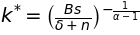

In [8]:
steadystate_k = sm.solve(steadystate,kstar)[0]
sm.Eq(kstar, steadystate_k)

We now have en expression for the steady state level of capital per capita. From (7) we know that the steady state level of output per capita kan be found as:

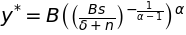

In [9]:
steadystate_y = sm.Eq(ystar, B*steadystate_k**alpha)
steadystate_y

We now have expressions for both capital and output per capita. 

## Numerical solution and interactive visualization

We solve for the real numbers of the steady state using the biseciton method. This depends on parameters $\alpha, s, B, n$ and $\delta$, which we set in the function. 

In [10]:
def bisect_ss(a,b, alpha=1/3, s=0.34, B=1, n=0.01, delta=0.03):
    
    """ 
    Input. Parameters of interest, and the interval [a,b]. This determines the interval on which the function evaluates 

    Output: Steady state value of capital per capita.  
    
    """
    result = optimize.bisect(lambda k: s*B*k**alpha - (n+delta)*k, a,b, full_output=False)
    return result

print(f'Steady state capital per capita for given parameter values is: {bisect_ss(1,100):.4f}')

Steady state capital per capita for given parameter values is: 24.7815


We now add en interactive element to the plot below. The following code allows the reader to use sliders to change paramter values $\alpha, s, n, \delta$ and $T$. The plot is a combination of the classic solow diagram where the intersection between $sBk^{\alpha}$ and $(n+\delta)k$ denotes the steady state level of capital per capita; and then an output diagram, where the steady state output $y_t$ shows as a function of capital per capita $k_t$. By combining the classic solow diagram with an output diagram, we allow to change the paramters, observe the intersection of the blue and the black line, and then go vertically up on the red line to find the corresponding steady state level of output per capita.  

First we define the function that creates the plot:

In [11]:
def simulate_solow(k,y,alpha,s,B,n,delta,T):
    """
    Input: varibales and paramters of interest
    
    Output: A compbination of the solow diagram and an output diagram.
    
    """
    
    # Create lists for k, diagonal line and y
    k_list = [k]
    diagonal = [0]
    y_list = [y]
    
    # Create the diagonal line
    for t in range(1,T):
        line = (n + delta)*t
        diagonal.append(line)
        
    # Create the Solow movement
    for t in range(1,T):
        k_plus = s*B*t**alpha
        k_list.append(k_plus)
    
    # Create the output graph
    for t in range(1,T):
        y_plus = B*t**alpha
        y_list.append(y_plus)
    
    # Plot
    plt.figure(figsize=(5,5))
    plt.plot(k_list[:T], label='$sBk_t^{\u03B1}$', color = 'blue')
    plt.plot(diagonal[:T], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(y_list[:T], label='$y_t$', color = 'red')
    plt.xlim(0,T)
    plt.ylim(0,6)
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    
    return plt.show()

And then we add the interactive sliders:

In [12]:
widgets.interact(simulate_solow, 
                k     = widgets.fixed(0), 
                y     = widgets.fixed(0),
                alpha = widgets.FloatSlider(description = '$\u03B1$' , min = 0 ,    max = 0.9 , step = 0.05 , value = 1/3),
                delta = widgets.FloatSlider(description = '$\u03B4$' , min = 0 ,    max = 0.1 , step = 0.01 , value = 0.03),
                s     = widgets.FloatSlider(description = 's' ,        min = 0.01 , max = 0.8 , step = 0.05 , value = 0.34),
                n     = widgets.FloatSlider(description ='$n$',        min = 0.01 , max = 0.1 , step = 0.005, value = 0.01),
                B     = widgets.fixed(1),
                T     = widgets.IntSlider(description='$T$' ,          min = 1,     max = 250, step = 1,    value = 100))

interactive(children=(FloatSlider(value=0.3333333333333333, description='$α$', max=0.9, step=0.05), FloatSlide…

<function __main__.simulate_solow(k, y, alpha, s, B, n, delta, T)>

# Model extension: The R&D based growth model

The extension of the solow model we choose is the R&D based growth model where we add technology $A_t$ to the model. The full model now looks as follows:

1. $Y_t = K_t^\alpha (A_t L_{Y_t})^{1-\alpha}$
* $A_{t+1} - A_t = \rho A_t^{\phi} L_{A_t}^{\lambda}$
* $K_{t+1} = sY_t + (1-\delta) K_t$
* $L_{t+1} = (1+n)L_t$
* $L_{Y_t} + L_{A_t} = L_t$
* $L_{A_t} = s_R L_t$

From equation (2) we introduce the technology growth, $g_t$.

$ g_t \equiv \frac{A_{t+1}-A_t}{A_t} = \rho A_t^{\phi-1} L_{A_t}^\lambda = \rho A_t^{\phi-1} (s_R L_t)^\lambda$

Defining capital and labor per effective capita:

$ \big(\frac{Y_t}{A_t L_t}\big) = \tilde{y}_t $ 

$ \big(\frac{K_t}{A_t L_t}\big) = \tilde{k}_t $ 

Which yields the following output per effective capita function:

7. $ \tilde{y}_t = \tilde{k}_t^\alpha (1-s_R)^{1-\alpha} $

The transition equation becomes the following:

$ \tilde{k}_{t+1} = \frac{1}{(1+n)(1+g_t)} [s\tilde{k}_t^\alpha (1-s_R)^{1-\alpha} + (1-\delta) \tilde{k}_t]$


## Analytical solution

The approah to solving this model is exactly the same as the basic solow model above. We start by defining all sm.symbols:

In [13]:
A = sm.symbols("A_t")                  # Technology
Ly = sm.symbols("L_{Y_t}")             # Labor input, (non-technology)
La = sm.symbols("L_{A_t}")             # Labor input, technology
sr = sm.symbols("s_R")                 # Labor share in research
g = sm.symbols("g_t")                  # Technology growth
phi = sm.symbols("phi")                 
rho = sm.symbols("rho")                 
lambd = sm.symbols("lambda")           
ktilde = sm.symbols("ktilde_t")        # Capital per effective capita
ytilde = sm.symbols("ytilde_t")        # Output per effective capita
ktildestar = sm.symbols("ktilde^*")    # Steady state capital per effective capita
ytildestar = sm.symbols("ytilde^*")    # Steady state capital per effective capita

Assuming that $\tilde{k}_{t+1} = \tilde{k}_t = \tilde{k}^*$ allows us to set up the steady state equation from the transition equation:

In [14]:
steadystatetilde = sm.Eq(ktildestar, (s*ktildestar**alpha*(1-sr)**(1-alpha)+(1-delta)*ktildestar)/((1+n)*(1+g)))

Solving for steady state capital per effective capita with sm.solve:

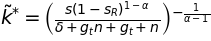

In [15]:
steadystatetilde_k = sm.solve(steadystatetilde,ktildestar)[0]
sm.Eq(ktildestar, steadystatetilde_k)

... and for output per effective capita:

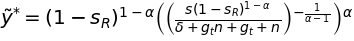

In [16]:
steadystatetilde_y = sm.Eq(ytildestar, steadystatetilde_k**alpha*(1-sr)**(1-alpha))
steadystatetilde_y

## Numerical solution

In [17]:
def bisect_sstilde(a,b, alpha=1/3, s=0.34, sr=0.05 , n=0.01, g=0.02, delta=0.03):
    
    """ 
    Input. Parameters of interest, and the interval [a,b]. This determines the interval on which the function evaluates 

    Output: Steady state value of capital per capita.  
    
    """
    result_tilde = optimize.bisect(lambda ktilde: s*ktilde**alpha*(1-sr)**(1-alpha) - (delta+g+n+n*g)*ktilde, a,b, full_output=False)
    return result_tilde

print(f'Steady state capital per effective capita for given parameter values is: {bisect_sstilde(1,100):.4f}')

Steady state capital per effective capita for given parameter values is: 12.7511


We now add the interactive plot, allowing us to change the same paramters as before, but now also the technology growth $g_t$.

First the plot function:

In [18]:
def simulate_solowRD(ktilde,ytilde,alpha,s,sr,n,g,delta,T):
    """
    Input: varibales and paramters of interest
    
    Output: A compbination of the solow diagram and an output diagram.
    
    """
    
    # Create lists for k, diagonal line and y
    ktilde_list = [ktilde]
    diagonaltilde = [0]
    ytilde_list = [ytilde]
    
    # Create the diagonal line
    for t in range(1,T):
        linetilde = (delta+g+n+n*g)*t
        diagonaltilde.append(linetilde)
        
    # Create the Solow movement
    for t in range(1,T):
        ktilde_plus = s*t**alpha*(1-sr)**(1-alpha)
        ktilde_list.append(ktilde_plus)
    
    # Create the output graph
    for t in range(1,T):
        ytilde_plus = t**alpha*(1-sr)**(1-alpha)
        ytilde_list.append(ytilde_plus)
    
    # Plot
    plt.figure(figsize=(5,5))
    plt.plot(ktilde_list[:T], label='$s \~{k}_t^{\u03B1}(1-s_R)^{1-\u03B1}$', color = 'blue')
    plt.plot(diagonaltilde[:T], label = '$(\delta+g+n+ng) \~{k}_t$', color = 'black')
    plt.plot(ytilde_list[:T], label='$\~{y}_t$', color = 'red')
    plt.xlim(0,T)
    plt.ylim(0,6)
    plt.xlabel('$\~{k}_t$')
    plt.grid(True)
    plt.legend()
    
    return plt.show()

... And the interactive sliders:

In [19]:
widgets.interact(simulate_solowRD, 
                ktilde     = widgets.fixed(0), 
                ytilde     = widgets.fixed(0),
                alpha = widgets.FloatSlider(description = '$\u03B1$' , min = 0 ,    max = 0.9 , step = 0.05 , value = 1/3),
                delta = widgets.FloatSlider(description = '$\u03B4$' , min = 0 ,    max = 0.1 , step = 0.01 , value = 0.03),
                s     = widgets.FloatSlider(description = 's' ,        min = 0.01 , max = 0.8 , step = 0.05 , value = 0.34),
                n     = widgets.FloatSlider(description ='$n$',        min = 0.01 , max = 0.1 , step = 0.005, value = 0.01),
                g     = widgets.FloatSlider(description ='$g$',        min = 0.01 , max = 0.1 , step = 0.005, value = 0.02),
                T     = widgets.IntSlider(description='$T$' ,          min = 1,     max = 250, step = 1,    value = 100),
                sr    = widgets.FloatSlider(description ='$s_R$',      min = 0.01 , max = 0.5 , step = 0.01, value = 0.05))

interactive(children=(FloatSlider(value=0.3333333333333333, description='$α$', max=0.9, step=0.05), FloatSlide…

<function __main__.simulate_solowRD(ktilde, ytilde, alpha, s, sr, n, g, delta, T)>

# Conclusion

We can conclude that we succesfully created an algorithm that solved the basic Solow model for steady state levels of per-capita capital and output. We also succesfully created interactive sliders, allowing the reader to change the paramters of the model as the reader wishes. The model is set up with examples of realistic paramter values, which can then easily be changed after the plot is created. 
After analyzing the basic solow model, we looked into the extended R&D based growth model, including technology and technology growth. We can conclude that the method of finding steady state levels does not change much, but that the levels themselves in the extended model depend on both technology growth $g$ and also the share of labor used in Research and development $s_R$. 